**ERA 5 Runs:**

In [1]:
RUNS={
    '025deg_era5':['025deg_era5_iaf'], #(our name: run name(s))
    '025deg_jra55': ['025deg_jra55_iaf_era5comparison'],
    '1deg_era5':['1deg_era5_iaf'],
    '1deg_jra55':['1deg_jra55_iaf_era5comparison']
}


In [54]:
VARS=['daidtt_m', 'daidtd_m', 'flat_ai_m', 'fsens_ai_m', 'meltb_m'] 
#thermo tendency, dynamic tendency, latent heat flux, sensible heat flux
VARS_2D=['area_t','geolat_t','geolon_t']

Check conda/analysis version

In [3]:
! conda env list

# conda environments:
#
                         /g/data/gv90/as2285/miniconda3
                         /g/data/gv90/as2285/miniconda3/envs/sea-ice-extremes
                         /g/data/gv90/as2285/miniconda3/envs/sea-ice-plots
                         /g/data/gv90/as2285/miniconda3/envs/sea-ice-tracker
base                  *  /g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07
access-nri-intake-test     /scratch/tm70/as2285/conda/envs/access-nri-intake-test
nmltab                   /scratch/tm70/as2285/conda/envs/nmltab



Create a work directory:

In [4]:
_scratch_path = !echo /scratch/$PROJECT/$USER/

_work_path=_scratch_path[0]+'era5_datastore/'

In [5]:
cd {_work_path}

/scratch/tm70/as2285/era5_datastore


Load modules:

In [6]:
import intake

import matplotlib.pyplot as plt
from dask.distributed import Client
from datetime import timedelta
import cf_xarray as cfxr
import cartopy.crs as ccrs
import xarray as xr
import xesmf
import numpy as np
import cmocean.cm as cmo

from datatree import DataTree,map_over_subtree


Load the open_run function

In [7]:
_notebook_path= !echo /g/data/$PROJECT/$USER/

_notebook_path=_notebook_path[0]+'access_analysis/access_om2_era5_jra/'

%run '{_notebook_path}/CICE_Loaders.ipynb'

In [8]:
client = Client()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35865 instead
  warnings.warn(


In [9]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/35865/status,
Dashboard: /proxy/35865/status,Workers: 4
Total threads: 12,Total memory: 46.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39061,Workers: 4
Dashboard: /proxy/35865/status,Total threads: 12
Started: Just now,Total memory: 46.00 GiB
Comm: tcp://127.0.0.1:35067,Total threads: 3
Dashboard: /proxy/36483/status,Memory: 11.50 GiB
Nanny: tcp://127.0.0.1:32925,


Open the catalog

In [10]:
catalog=intake.open_df_catalog(
    'metacatalog.csv', 
    columns_with_iterables=['model','realm','frequency', 'variable']
)

# Load the ERA5 runs

In [55]:
%%time

si_dt = DataTree.from_dict(dict([
    (iRun, open_by_run(iRun, VARS)) for iRun in RUNS.keys()
]))

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/intake_esm/cat.py:270: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(type)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/intake_esm/cat.py:270: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(type)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/intake_esm/cat.py:270: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(type)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/intake_esm/cat.py:270: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(type)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/intake_esm/cat.py:270: FutureWarning: DataFrame.applymap has been deprecated. Use D

CPU times: user 52.6 s, sys: 3.86 s, total: 56.5 s
Wall time: 3min 33s


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/intake_esm/cat.py:270: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(type)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/intake_esm/cat.py:270: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(type)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/intake_esm/cat.py:270: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(type)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/intake_esm/cat.py:270: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(type)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/intake_esm/cat.py:270: FutureWarning: DataFrame.applymap has been deprecated. Use D

In [56]:
@map_over_subtree
def match_timestamps_to_NSIDC(cice_ds):

    # we are going to use the same timestamps as NSIDC
    cice_ds['time'] = [np.datetime64(str(i)[0:7]+'-01T00:00:00.000000000') for i in cice_ds.time.values]

    return cice_ds

In [57]:
si_dt = match_timestamps_to_NSIDC(si_dt)

In [58]:
si_dt

DataTree('None', parent=None)
├── DataTree('025deg_era5')
│       Dimensions:     (time: 523, yt_ocean: 1080, xt_ocean: 1440)
│       Coordinates:
│         * time        (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2023-07-01
│         * xt_ocean    (xt_ocean) float64 -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
│         * yt_ocean    (yt_ocean) float64 -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
│           geolat_t    (yt_ocean, xt_ocean) float32 ...
│           geolon_t    (yt_ocean, xt_ocean) float32 ...
│           area_t      (yt_ocean, xt_ocean) float32 ...
│       Data variables:
│           meltb_m     (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
│           flat_ai_m   (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
│           daidtt_m    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
│           daidtd_m    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
│           fsens_ai_m  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
│       Attributes: (12/16)
│           title:                                    sea ice model output for CICE
│           contents:                                 Diagnostic and Prognostic Varia...
│           source:                                   Los Alamos Sea Ice Model (CICE)...
│           time_period_freq:                         month_1
│           comment3:                                 seconds elapsed into model date...
│           conventions:                              CF-1.0
│           ...                                       ...
│           intake_esm_attrs:variable_long_name:      boundaries for time-averaging i...
│           intake_esm_attrs:variable_standard_name:  
│           intake_esm_attrs:variable_cell_methods:   time: mean,time: mean,time: mea...
│           intake_esm_attrs:file_id:                 iceh_XXXX_XX
│           intake_esm_attrs:_data_format_:           netcdf
│           intake_esm_dataset_key:                   iceh_XXXX_XX.1mon
├── DataTree('025deg_jra55')
│       Dimensions:     (time: 523, yt_ocean: 1080, xt_ocean: 1440)
│       Coordinates:
│         * time        (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2023-07-01
│         * xt_ocean    (xt_ocean) float64 -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
│         * yt_ocean    (yt_ocean) float64 -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
│           geolat_t    (yt_ocean, xt_ocean) float32 ...
│           geolon_t    (yt_ocean, xt_ocean) float32 ...
│           area_t      (yt_ocean, xt_ocean) float32 ...
│       Data variables:
│           daidtd_m    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
│           fsens_ai_m  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
│           daidtt_m    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
│           meltb_m     (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
│           flat_ai_m   (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
│       Attributes: (12/16)
│           title:                                    sea ice model output for CICE
│           contents:                                 Diagnostic and Prognostic Varia...
│           source:                                   Los Alamos Sea Ice Model (CICE)...
│           time_period_freq:                         month_1
│           comment3:                                 seconds elapsed into model date...
│           conventions:                              CF-1.0
│           ...                                       ...
│           intake_esm_attrs:variable_long_name:      boundaries for time-averaging i...
│           intake_esm_attrs:variable_standard_name: 

December

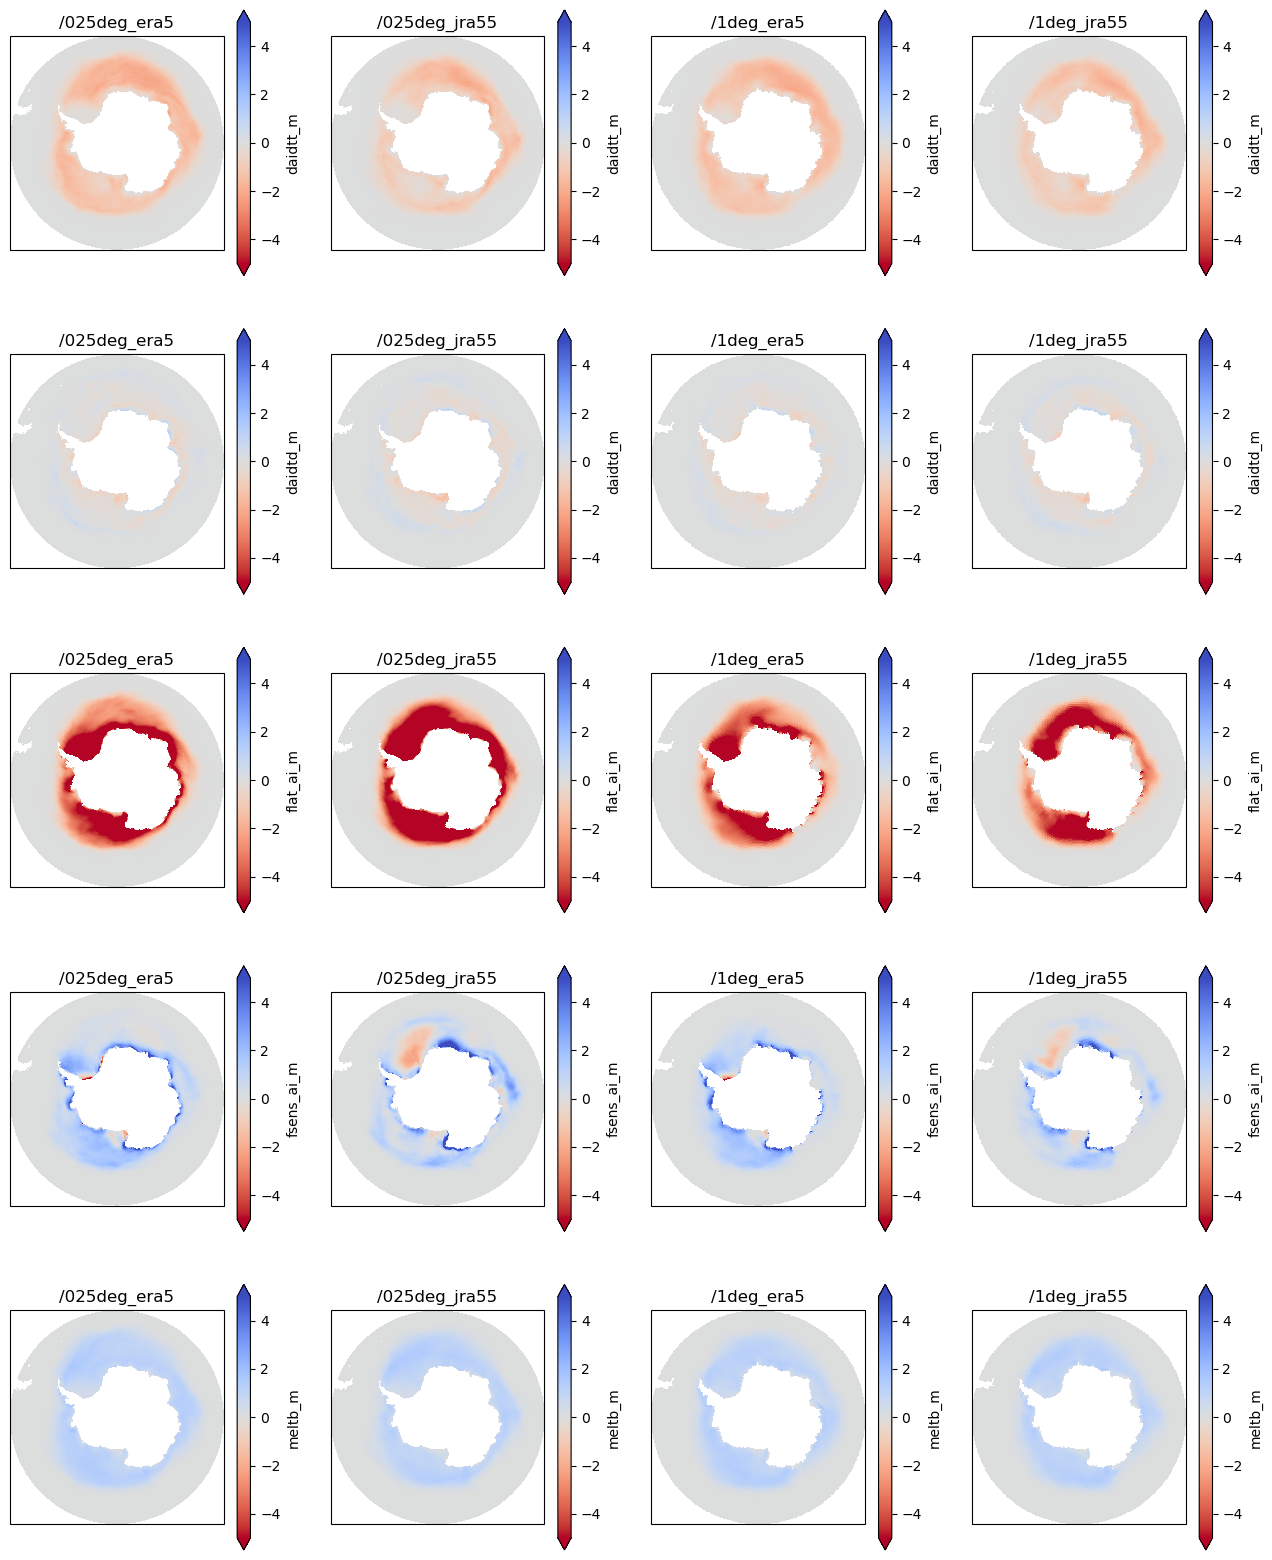

In [59]:
times=[12] #np.arange(1,13)

nRows = len(VARS)*len(times)
nCols = len(si_dt.groups)

plt.figure(figsize=(4*nCols,4*nRows))
j=0

for iVar in VARS:

    i=1
    
    for iGroup in si_dt.groups[1:]:
        ds=si_dt[iGroup].ds[iVar].sel(yt_ocean=slice(-90,-50))
        
        ds=ds.sel(time=ds.time.dt.month.isin(times[0])).mean('time')
           
        ax = plt.subplot(nRows,nCols,i+j*nCols,projection=ccrs.SouthPolarStereo(true_scale_latitude=-70))

        ds.plot(
            transform=ccrs.PlateCarree(),
            vmin=-5, vmax=5,
            cmap='coolwarm_r',
            extend='both'
        )

        plt.title(iGroup)

        i+=1

    j+=1


Sep

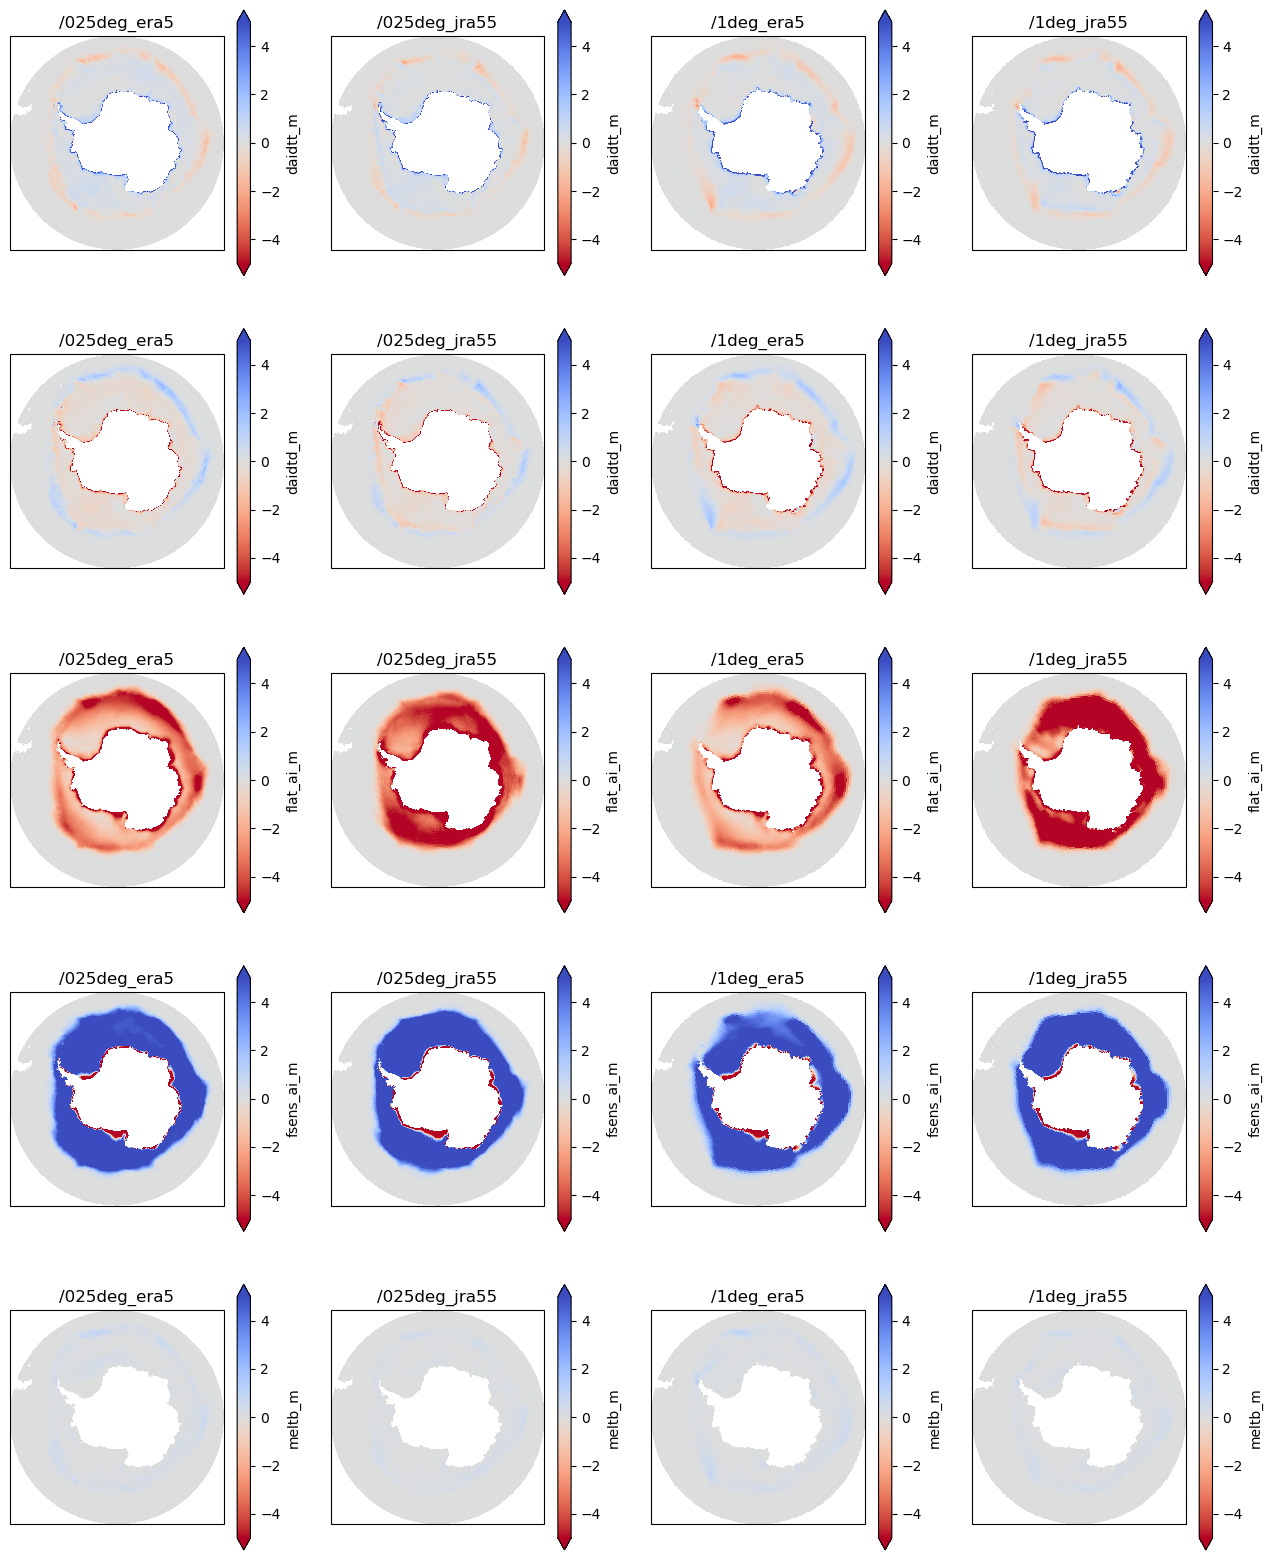

In [60]:
times=[9] #np.arange(1,13)

nRows = len(VARS)*len(times)
nCols = len(si_dt.groups)

plt.figure(figsize=(4*nCols,4*nRows))
j=0

for iVar in VARS:

    i=1
    
    for iGroup in si_dt.groups[1:]:
        ds=si_dt[iGroup].ds[iVar].sel(yt_ocean=slice(-90,-50))
        
        ds=ds.sel(time=ds.time.dt.month.isin(times[0])).mean('time')
           
        ax = plt.subplot(nRows,nCols,i+j*nCols,projection=ccrs.SouthPolarStereo(true_scale_latitude=-70))

        ds.plot(
            transform=ccrs.PlateCarree(),
            vmin=-5, vmax=5,
            cmap='coolwarm_r',
            extend='both'
        )

        plt.title(iGroup)

        i+=1

    j+=1


Feb

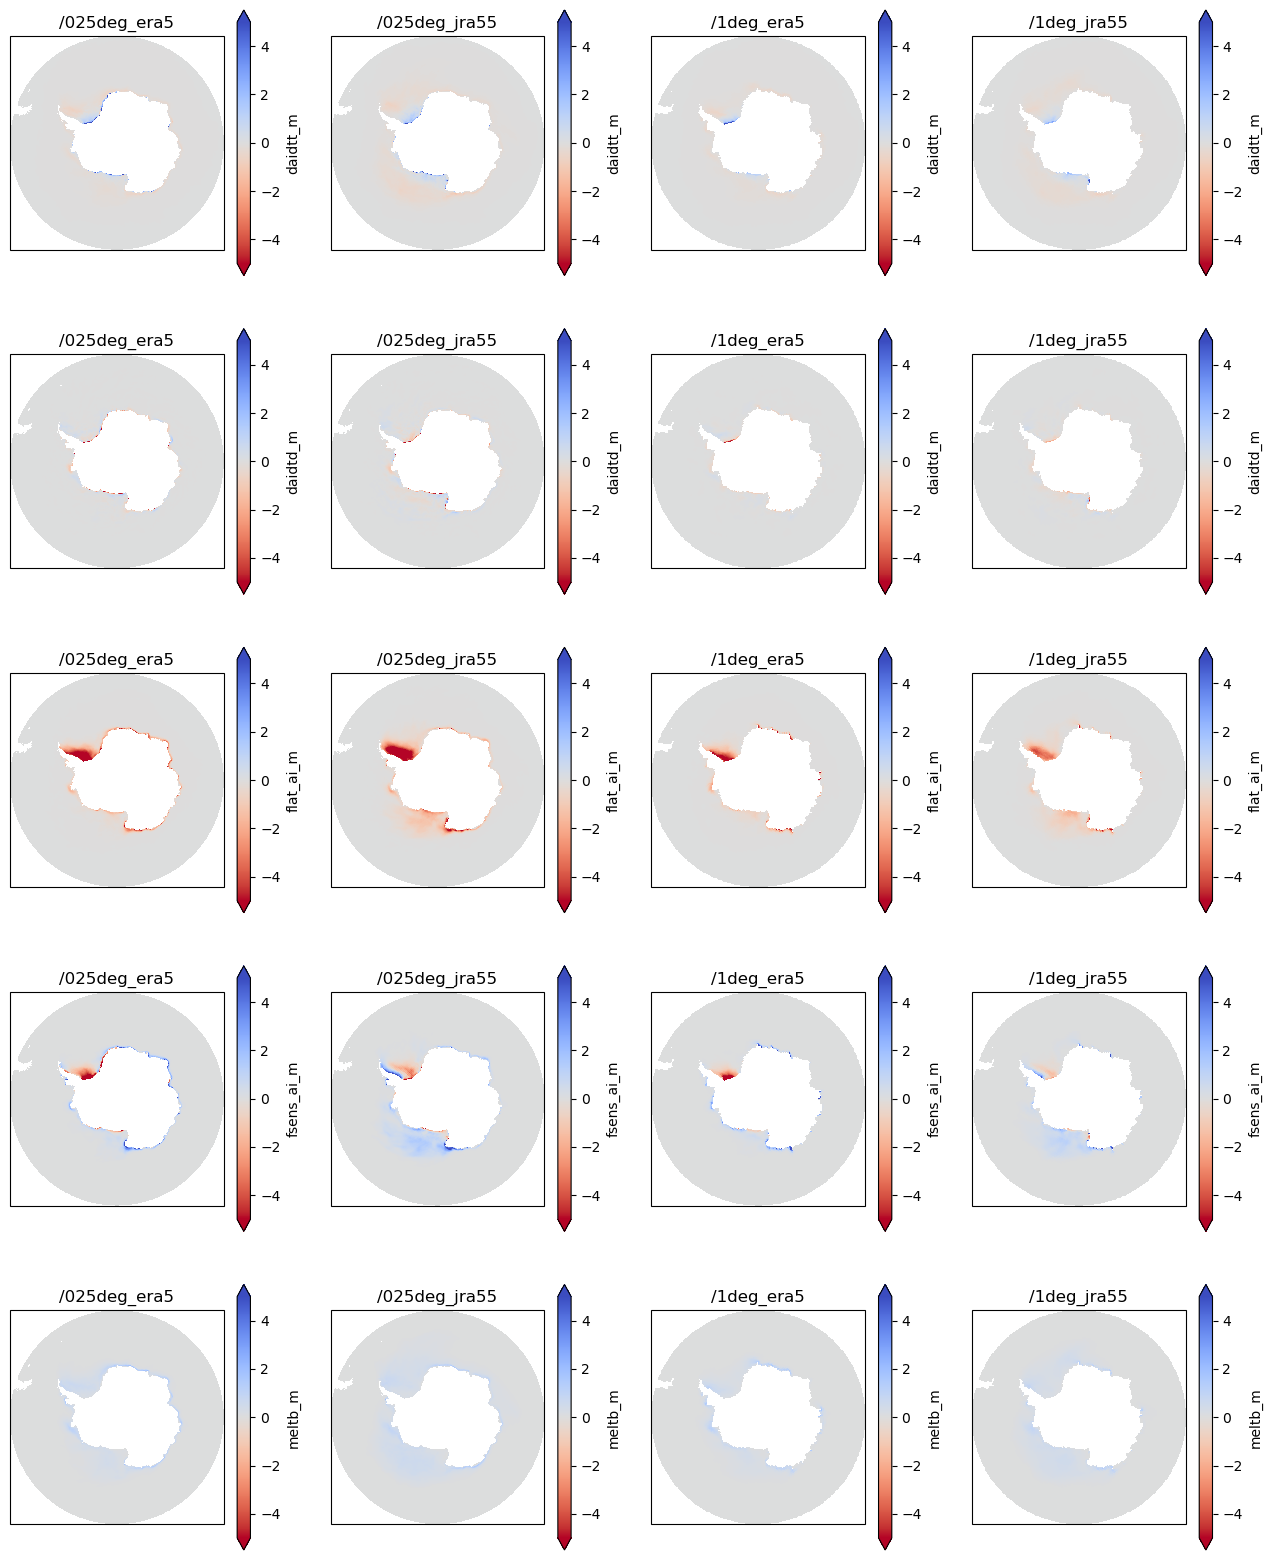

In [61]:
times=[2] #np.arange(1,13)

nRows = len(VARS)*len(times)
nCols = len(si_dt.groups)

plt.figure(figsize=(4*nCols,4*nRows))
j=0

for iVar in VARS:

    i=1
    
    for iGroup in si_dt.groups[1:]:
        ds=si_dt[iGroup].ds[iVar].sel(yt_ocean=slice(-90,-50))
        
        ds=ds.sel(time=ds.time.dt.month.isin(times[0])).mean('time')
           
        ax = plt.subplot(nRows,nCols,i+j*nCols,projection=ccrs.SouthPolarStereo(true_scale_latitude=-70))

        ds.plot(
            transform=ccrs.PlateCarree(),
            vmin=-5, vmax=5,
            cmap='coolwarm_r',
            extend='both'
        )

        plt.title(iGroup)

        i+=1

    j+=1


In [62]:
client.close()

2023-11-08 13:48:15,978 - distributed.nanny - WARNING - Worker process still alive after 3.19999740600586 seconds, killing
2023-11-08 13:48:15,979 - distributed.nanny - WARNING - Worker process still alive after 3.1999989318847657 seconds, killing
2023-11-08 13:48:15,982 - distributed.nanny - WARNING - Worker process still alive after 3.1999992370605472 seconds, killing
2023-11-08 13:48:15,985 - distributed.nanny - WARNING - Worker process still alive after 3.1999992370605472 seconds, killing
